# Niche analysis with CellMapper and Sopa

This tutorial shows how CellMapper can be used to enrich latent spaces with spatial context to identify tissue niches, following the principles of UTAG and CellCharter (CITE). We also show how Sopa can be used to perform downstream analysis, following their tutorial (CITE). 

## Preliminaries

### Import packages & data

In [1]:
%load_ext autoreload
%autoreload 2

In [162]:
import scanpy as sc
import sopa
import matplotlib.colors as mcolors
import networkx as nx
from community import community_louvain
from netgraph import Graph

import numpy as np
import scvi

import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from cellmapper import CellMapper

import pandas as pd

In [3]:
sc.settings.set_figure_params(scanpy=True, frameon=False, fontsize=10)

Load the seqFISH data of {cite:p}`lohoff2022integration` as a spatial query dataset and the scRNA-seq data of {cite:p}`pijuan2019single` as a dissociated reference dataset. Both profile mouse embryogenesis at approximately embryonic day (E) 8.5. 

In [4]:
adata = sc.read("data/spatial_data.h5ad", backup_url="https://figshare.com/ndownloader/files/54145250")
adata

AnnData object with n_obs × n_vars = 51787 × 351
    obs: 'embryo', 'pos', 'z', 'embryo_pos', 'embryo_pos_z', 'Area', 'celltype_seqfish', 'sample_seqfish', 'umap_density_sample', 'modality', 'total_counts', 'n_counts', 'celltype_harmonized'
    uns: 'celltype_harmonized_colors', 'celltype_seqfish_colors', 'embryo_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_orig', 'spatial'
    varm: 'PCs'

### Basic preprocessing

In [5]:
adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

### Basic visualization

Let's take a closer look at this dataset before we get started. 

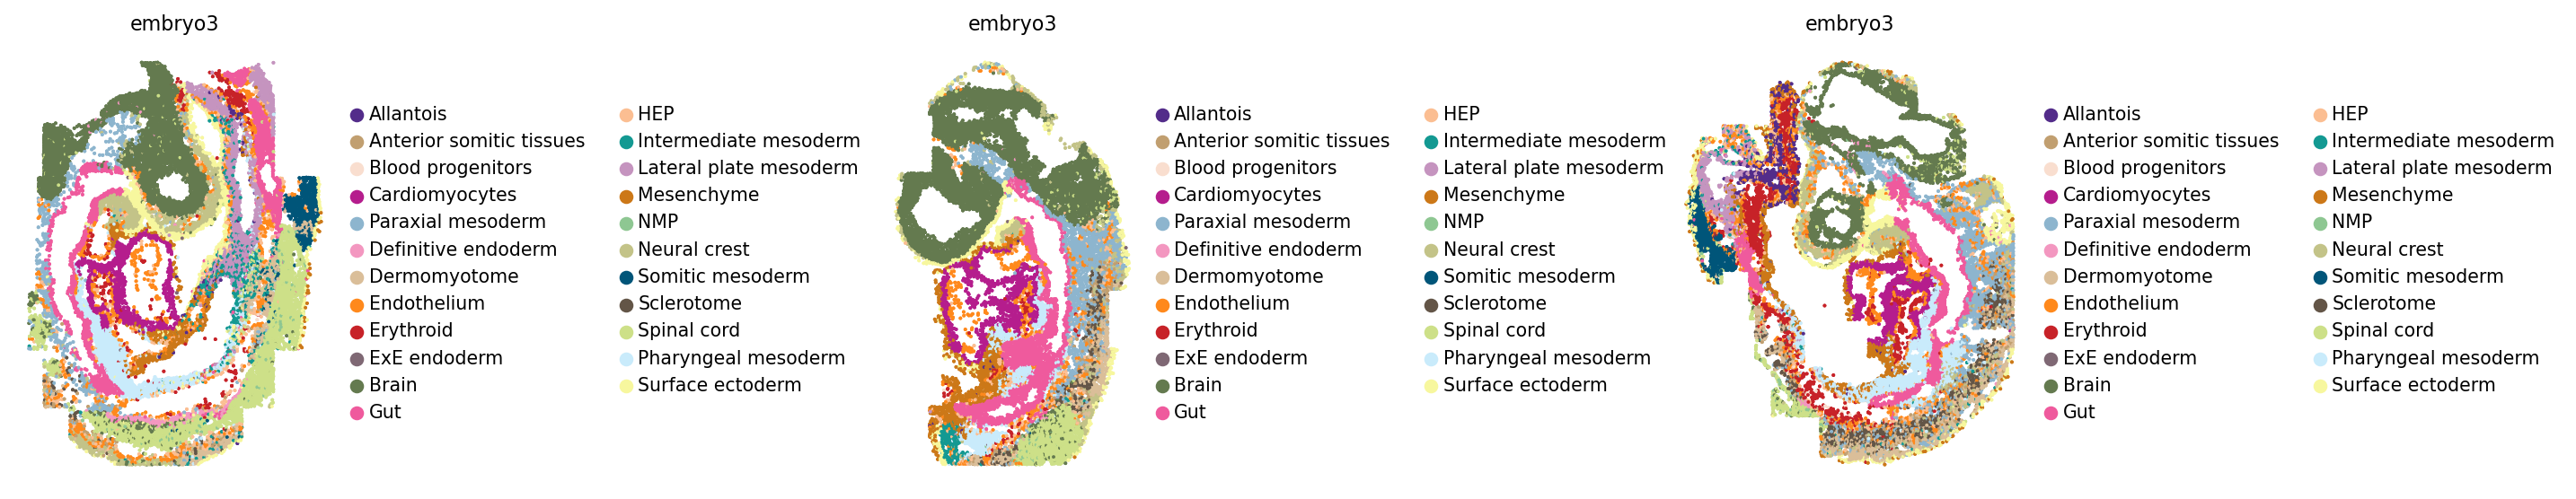

In [107]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sq.pl.spatial_scatter(
        adata,
        library_key="embryo",
        color="celltype_harmonized",
        shape=None,
        wspace=0.6,
    )

### Compute a joint embedding

For our niches to be shared across the different embryos, let's compute a joint embedding using scVI while correcting for the `embryo` batch label. This is a similar principle to the published CellCharter (CITE) method - we first compute a joint latent space across samples, which we will later on use for spatial contextualization. 

In [7]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="embryo")
vae = scvi.model.SCVI(adata, gene_likelihood="nb")

In [9]:
vae.train()
adata.obsm["scVI"] = vae.get_latent_representation()

/cluster/project/treutlein/USERS/mlange/miniforge3/envs/cellmapper_gpu/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cluster/project/treutlein/USERS/mlange/miniforge3/e ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/cluster/project/treutlein/USERS/mlange/miniforge3/envs/cellmapper_gpu/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cluster/project/treutlein/USERS/mlange/miniforge3/e ...
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you

Epoch 154/154: 100%|██████████| 154/154 [05:00<00:00,  1.91s/it, v_num=1, train_loss_step=273, train_loss_epoch=254]

`Trainer.fit` stopped: `max_epochs=154` reached.


Epoch 154/154: 100%|██████████| 154/154 [05:00<00:00,  1.95s/it, v_num=1, train_loss_step=273, train_loss_epoch=254]


Let's compute a UMAP in this joint latent space to visually convince us that samples are integrated. 

In [10]:
sc.pp.neighbors(adata, use_rep="scVI")
sc.tl.umap(adata, key_added="X_umap_scVI")

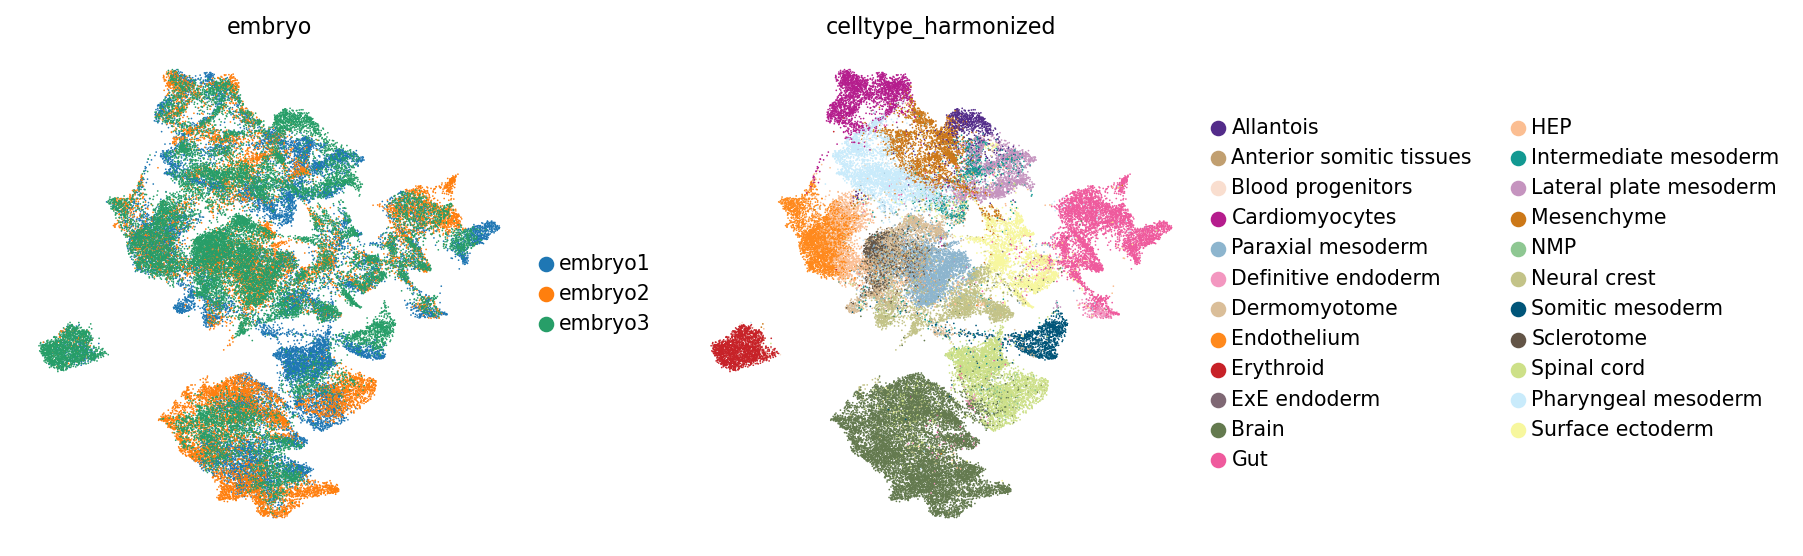

In [11]:
sc.pl.embedding(adata, basis="umap_scVI", color=["embryo", "celltype_harmonized"])

Looks good visually (we could evaluate this now more quantitatively using scIB metrics (CITE)). 

## Work with CellMapper

### Prepare spatial graph and CellMapper object

First, we need to compute a graph of neighborhood relatinships in space. For that, we can use squidpy. We'll use delaunay triangularization, to avoid having to pass a dataset-dependent radius, with a percentile specified to remove long-range connections. Also, we stratify by embryo, to make sure that cells can only have neighbors in their own coordinate system. 

In [136]:
sq.gr.spatial_neighbors(
    adata,
    coord_type="generic",
    library_key="embryo",
    spatial_key="spatial",
    delaunay=True,
    percentile=98,
)

mean_n_neighbors = np.sum(adata.obsp["spatial_connectivities"] != 0, axis=1).mean()
print(f"On average, each cell has {mean_n_neighbors:.2f} neighbors in space.")

On average, each cell has 5.86 neighbors in space.


Let's take a look at this graph in one example embryo. 

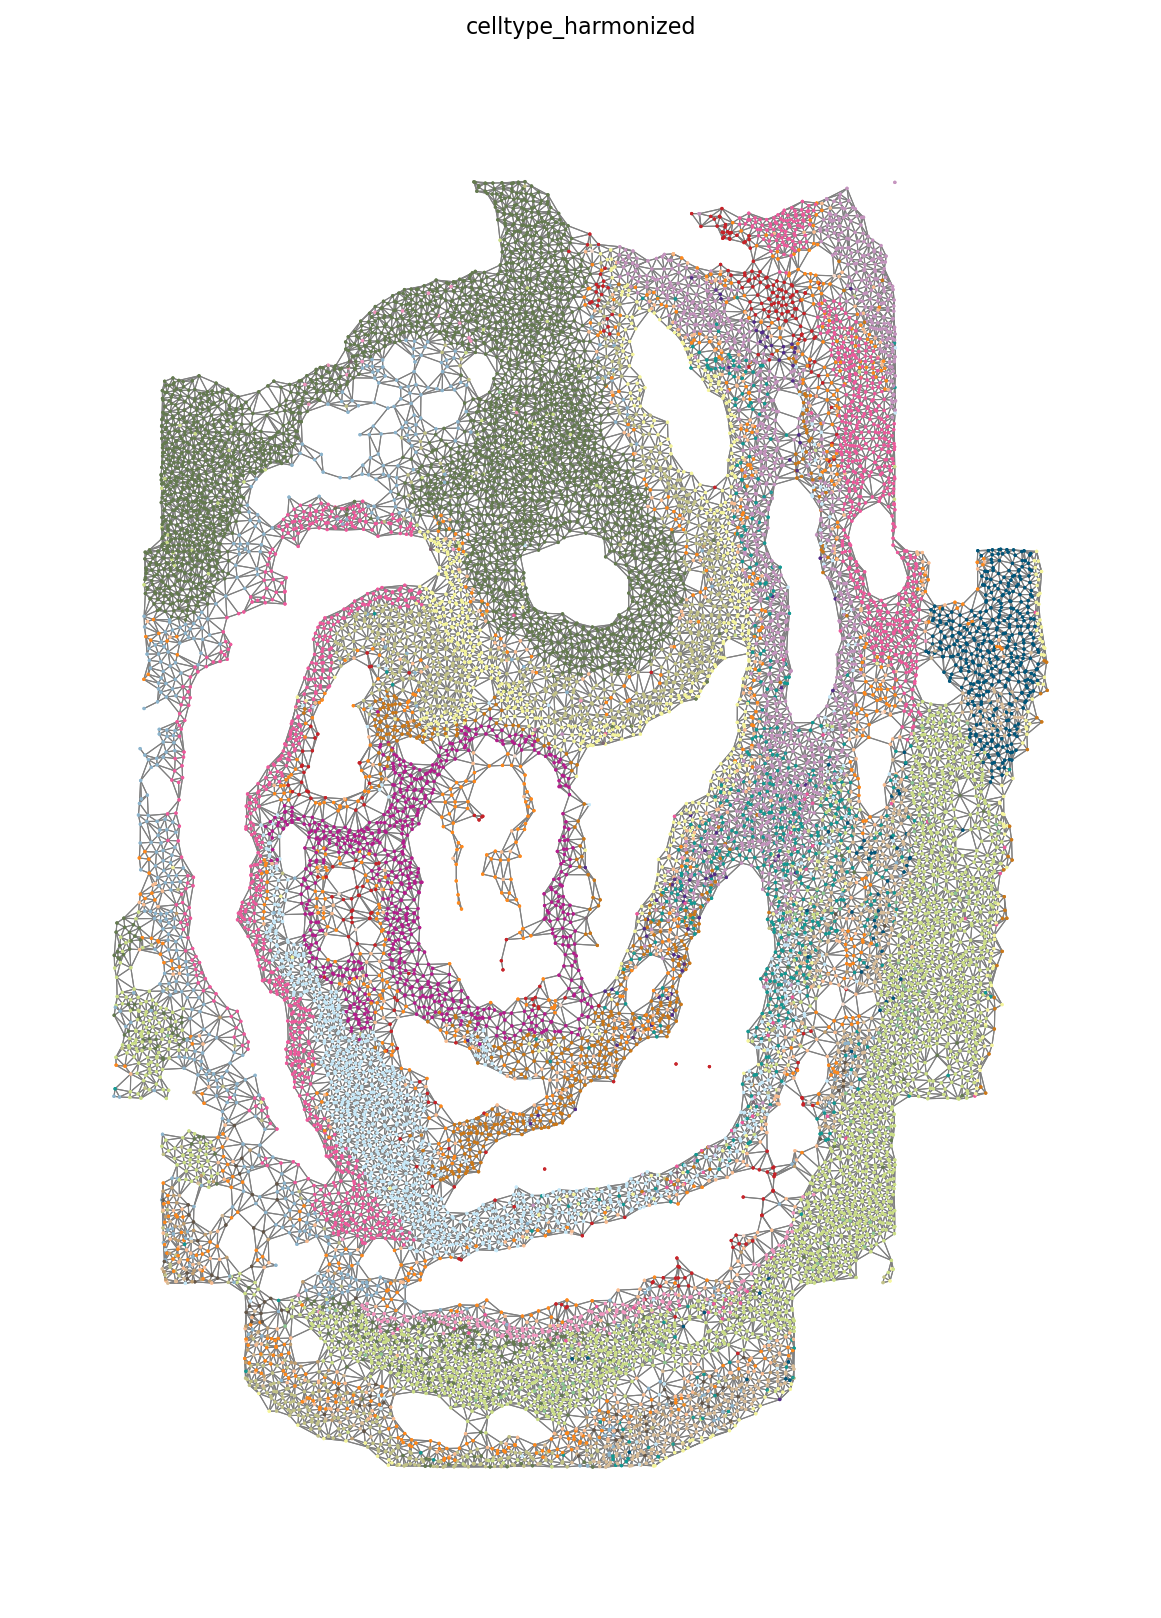

In [137]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sq.pl.spatial_scatter(
        adata,
        color="celltype_harmonized",
        library_key="embryo",
        library_id="embryo1",
        shape=None,
        size=1,
        connectivity_key="spatial_connectivities",
        edges_width=0.5,
        legend_loc=None,
        figsize=(10, 10),
    )

Initialize CellMapper in self-mapping mode, by providing only a single dataset. 

In [138]:
smap = CellMapper(adata)
smap

INFO     Initialized CellMapper for self-mapping with 51787 cells.                                                 


CellMapper(self-mapping, data=AnnData(n_obs=51,787, n_vars=351), 

Load pre-computed spatial neighborhood graph. 

In [139]:
smap.load_precomputed_distances("spatial_distances", include_self=True)

INFO     Created Neighbors object from distances matrix with 51787 cells                                           
INFO     Loaded precomputed distances from 'spatial_distances' with 51787 cells and 13 neighbors per cell.         


### Smooth embedding over spatial coordinates. 

Compute a mapping matrix - we'll give equal weight to neighboring cells. We could use any other CellMapper kernel function here.  

In [140]:
smap.compute_mappping_matrix(method="equal")

INFO     Computing mapping matrix using method 'equal'.                                                            
INFO     Row-normalizing the mapping matrix.                                                                       


To contextualize the latent space, we simply perform a matrix multiplication with our mapping matrix, which corresponds to a normalized version of the (embryo-stratified) spatial graph. 

In [141]:
smap.transfer_embeddings(obsm_keys="scVI", prediction_postfix="spatial")

INFO     Transferring embeddings for key 'scVI'.                                                                   
INFO     Embeddings transferred and stored in query.obsm['scVI_spatial'].                                          


### Cluster smoothed expression to obtain niches

There are plenty of niche identification algorithms out there by now, and most of them operate by somehow smoothing measured features over neighboring cells, to obtain a more aggregate view of the tissue at hand. We did the simplest version of that above, so let's see what we get when we cluster cells in this spatially contextualized scVI latent space. 

In [142]:
sc.pp.neighbors(adata, use_rep="scVI_spatial")
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=0.1, key_added="niche")

if "niche_colors" in adata.uns:
    del adata.uns["niche_colors"]

How do these niches co-localize with cell type annotations in the UMAP? 

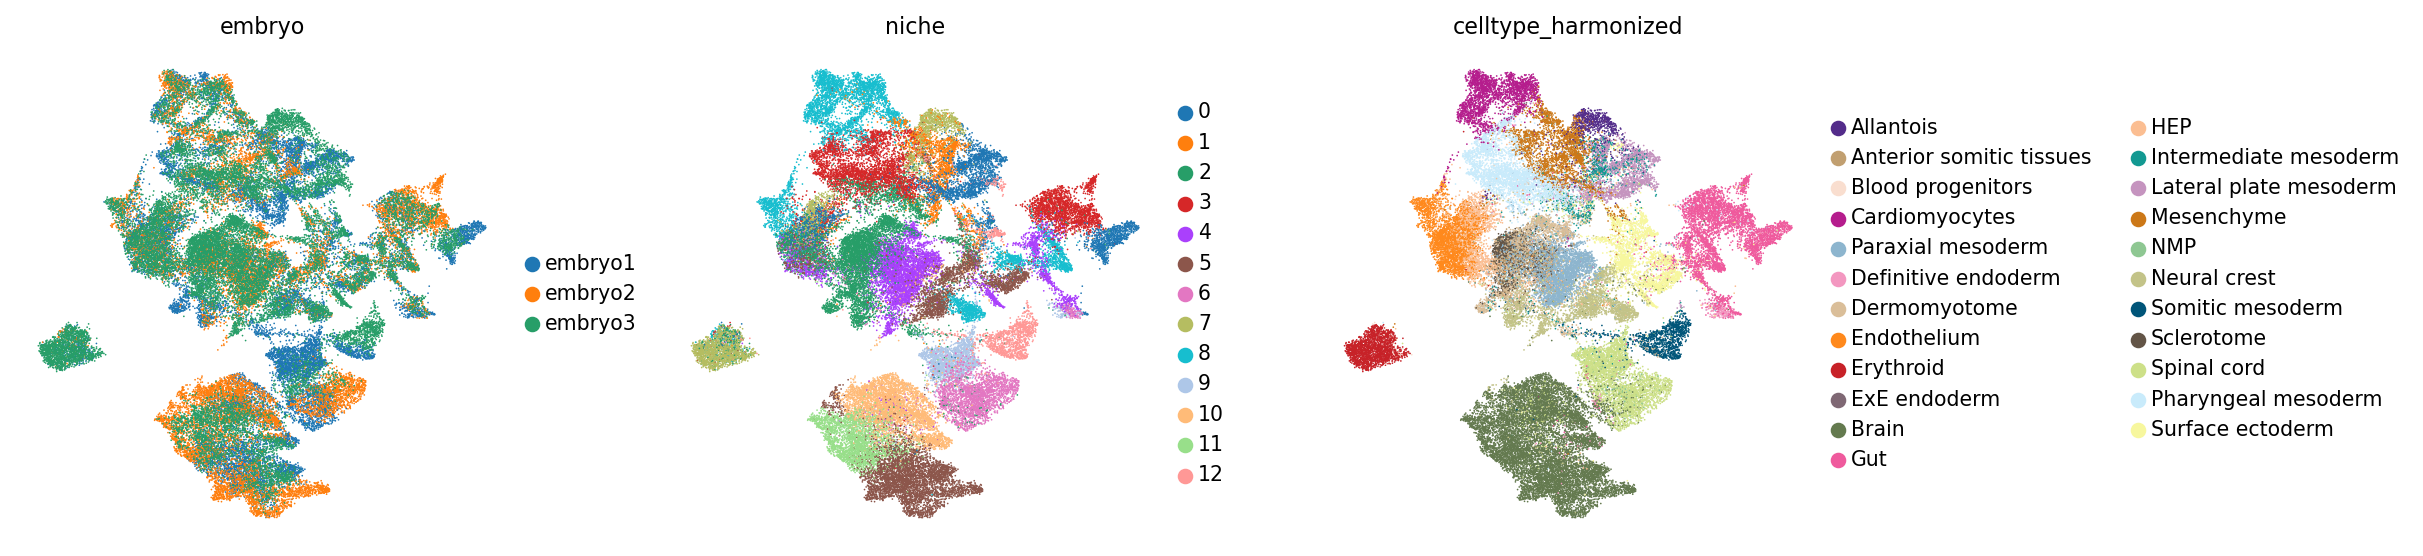

In [143]:
sc.pl.embedding(adata, basis="umap_scVI", color=["embryo", "niche", "celltype_harmonized"])

Let's plot these niches across embryos, alongside cell type annotations. 

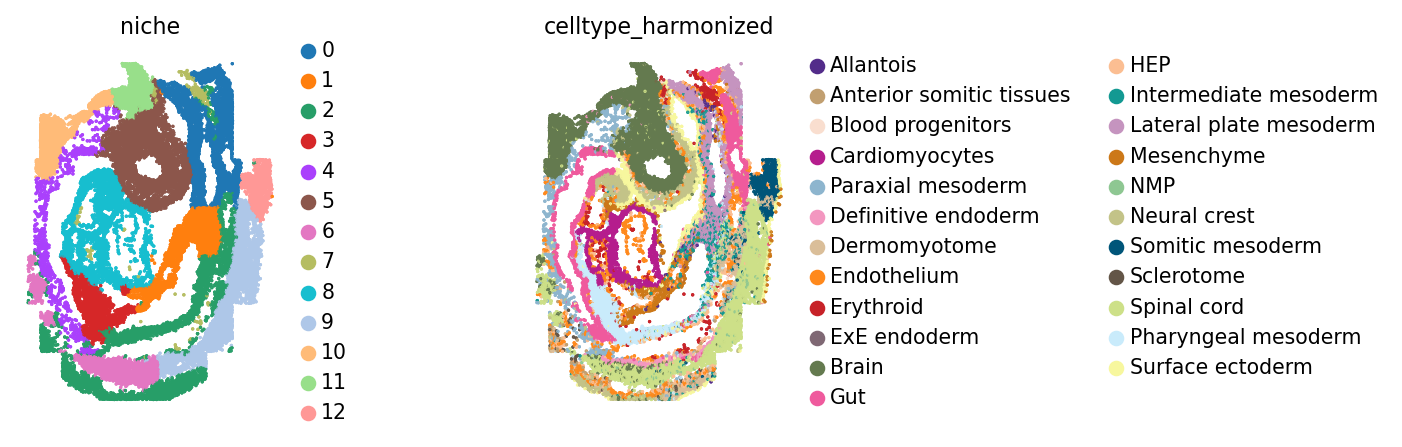

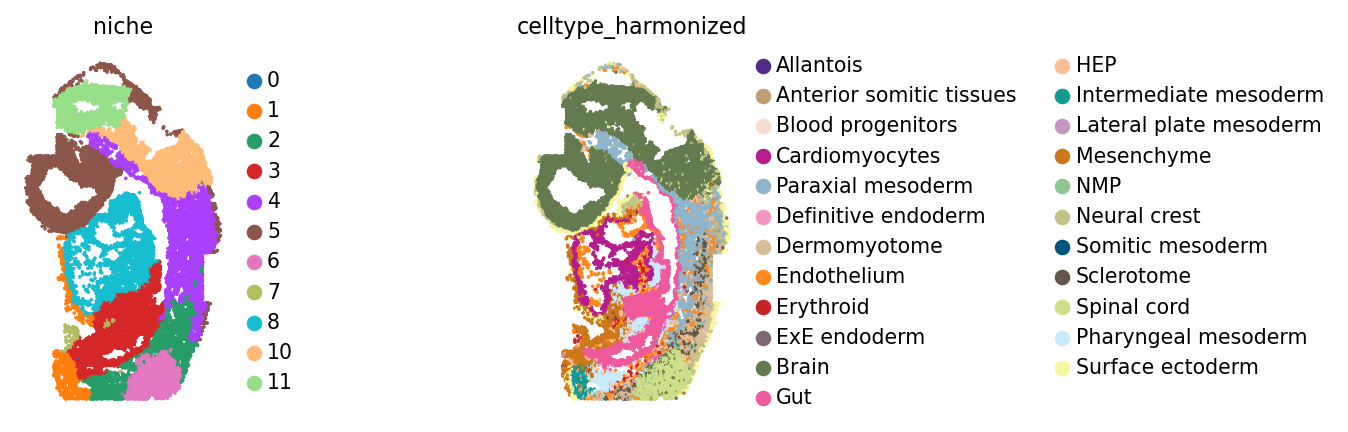

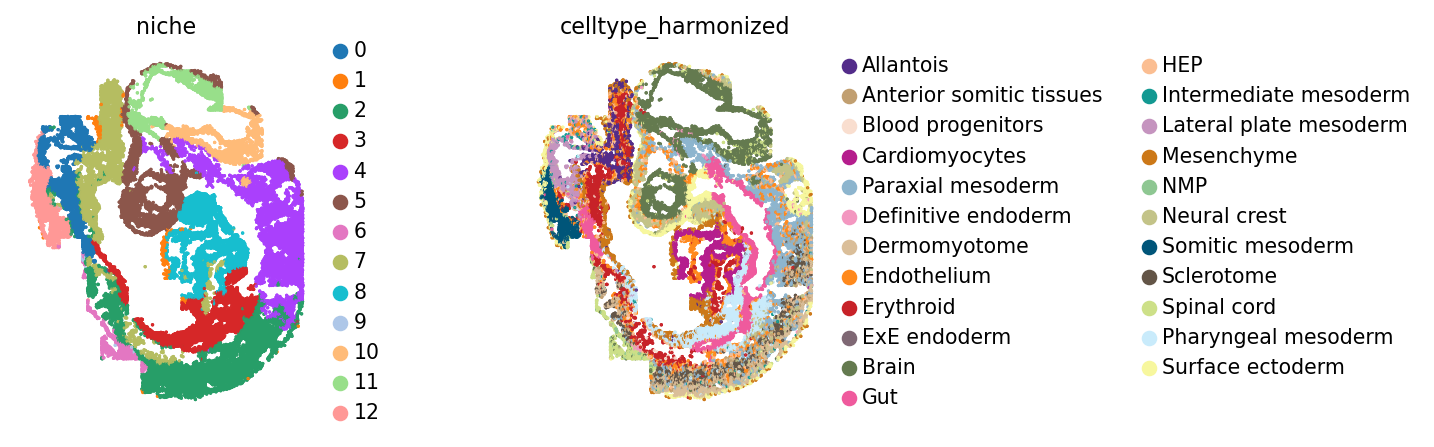

In [144]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for library_id in adata.obs["embryo"].cat.categories:
        sq.pl.spatial_scatter(
            adata,
            library_key="embryo",
            library_id=library_id,
            color=[
                "niche",
                "celltype_harmonized",
            ],
            shape=None,
            size=1,
            figsize=(4, 3),
            wspace=0,
        )

plt.show()

### Analyze niches

How are these niches related to cell types, across the different embryos? Are these niches really consistent across embryos? 

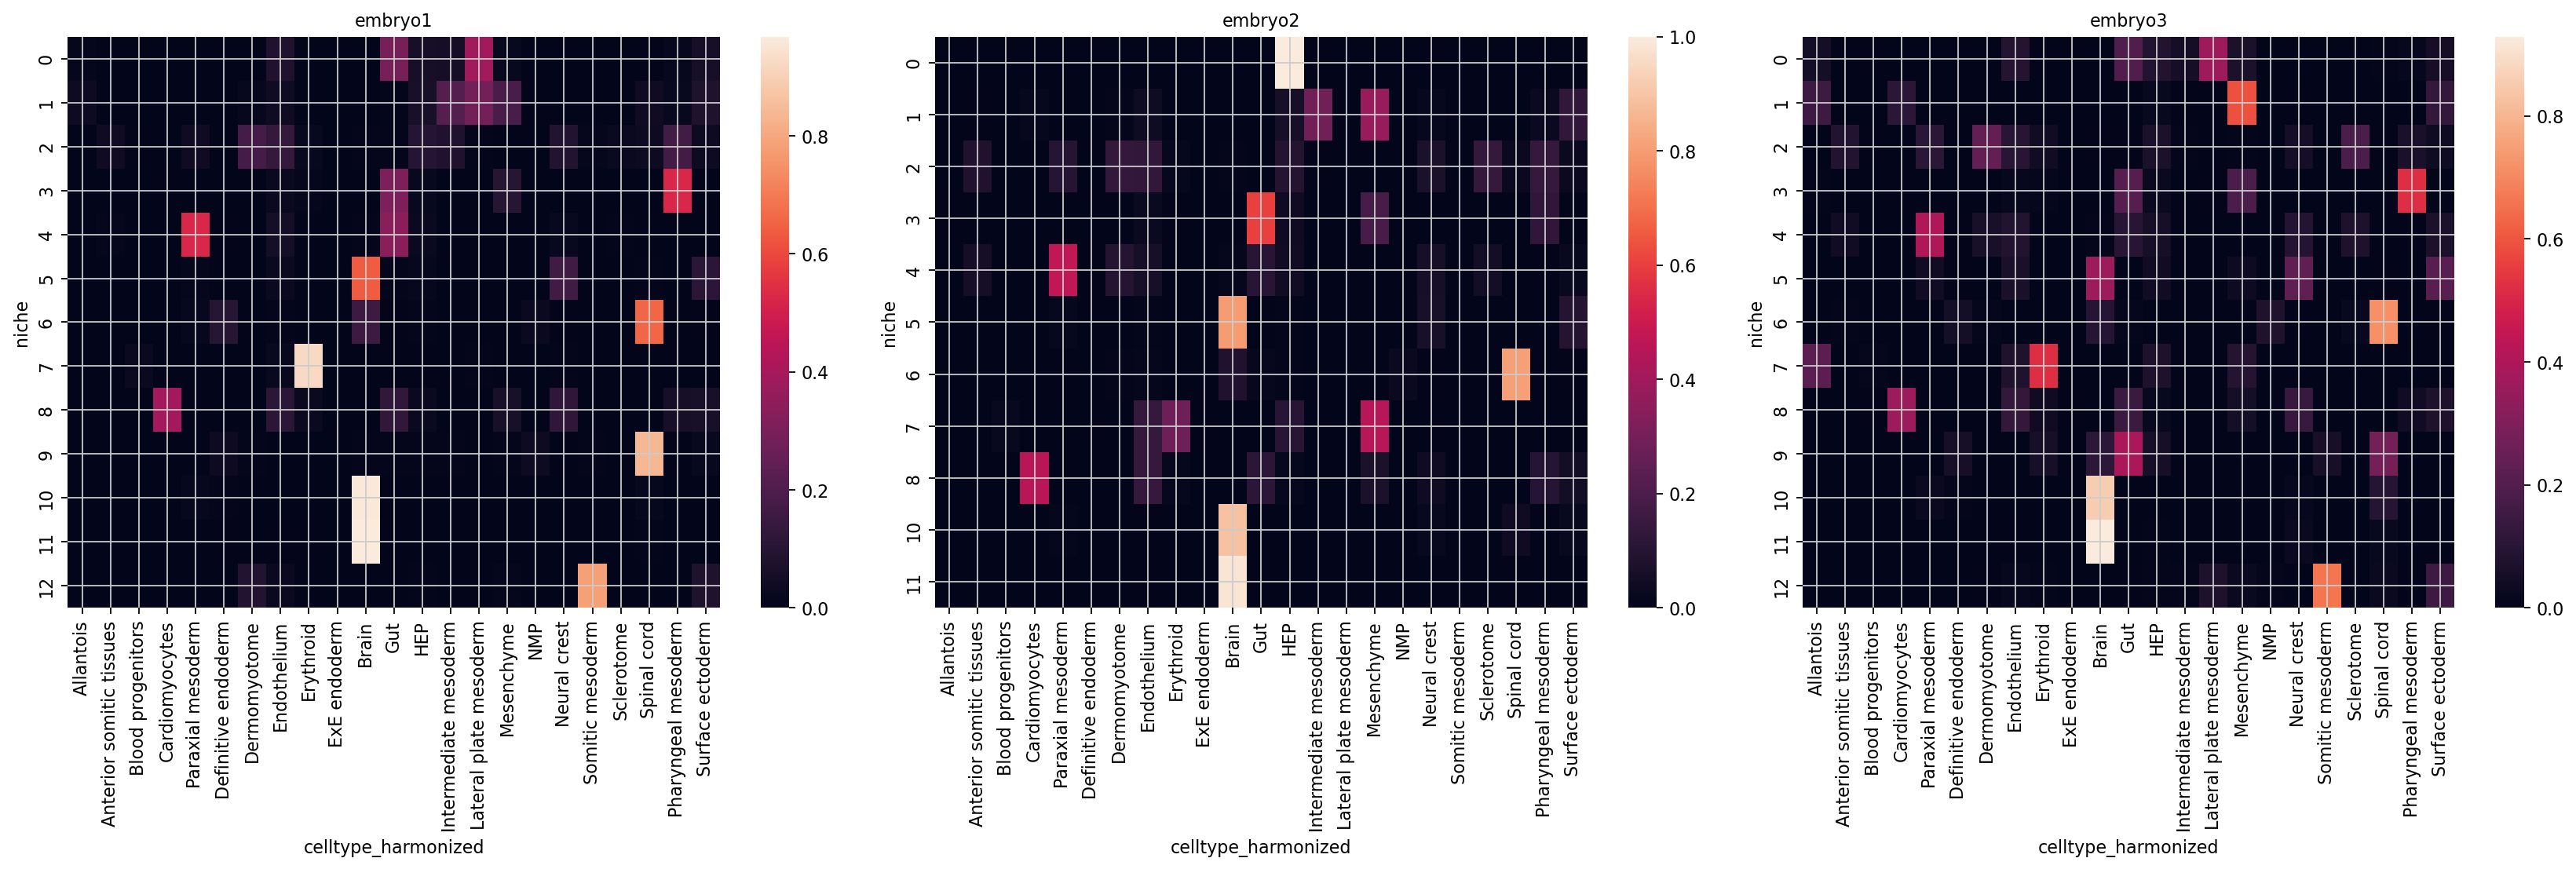

In [161]:
cats = adata.obs["embryo"].cat.categories
_, axes = plt.subplots(1, 3, figsize=(len(cats) * 7, 7))

for ax, cat in zip(axes, cats, strict=False):
    obs_mask = adata.obs["embryo"] == cat
    mat = pd.crosstab(adata[obs_mask].obs["niche"], adata[obs_mask].obs["celltype_harmonized"])
    mat = mat.div(mat.sum(axis=1), axis=0)
    ax = sns.heatmap(mat, ax=ax)
    ax.set_title(cat)

plt.tight_layout()

These niches look mostly consistent - for example, across all embryos, 10 and 11 are brain niches, 12 corresponds to somitic mesoderm, and 8 contains mostly cardiomyocytes with some gut and some neural crest cells. 

### Look into niche geometries

To gain further insights into the niches identified here, we can use Sopa (CITE). The remainder of this tutorial will closely follow Sopa's tutorial on Niche analysis. To simplify things, let's focus on just a single embryo from here on. 

In [243]:
bdata = adata[adata.obs["embryo"] == "embryo1"].copy()

First, let's look into the mean distances between niches - this will tell us which niches are localized next to another. 

First, we can compute the mean distance between cell types and niches. 

100%|██████████| 13/13 [00:00<00:00, 67.15it/s]


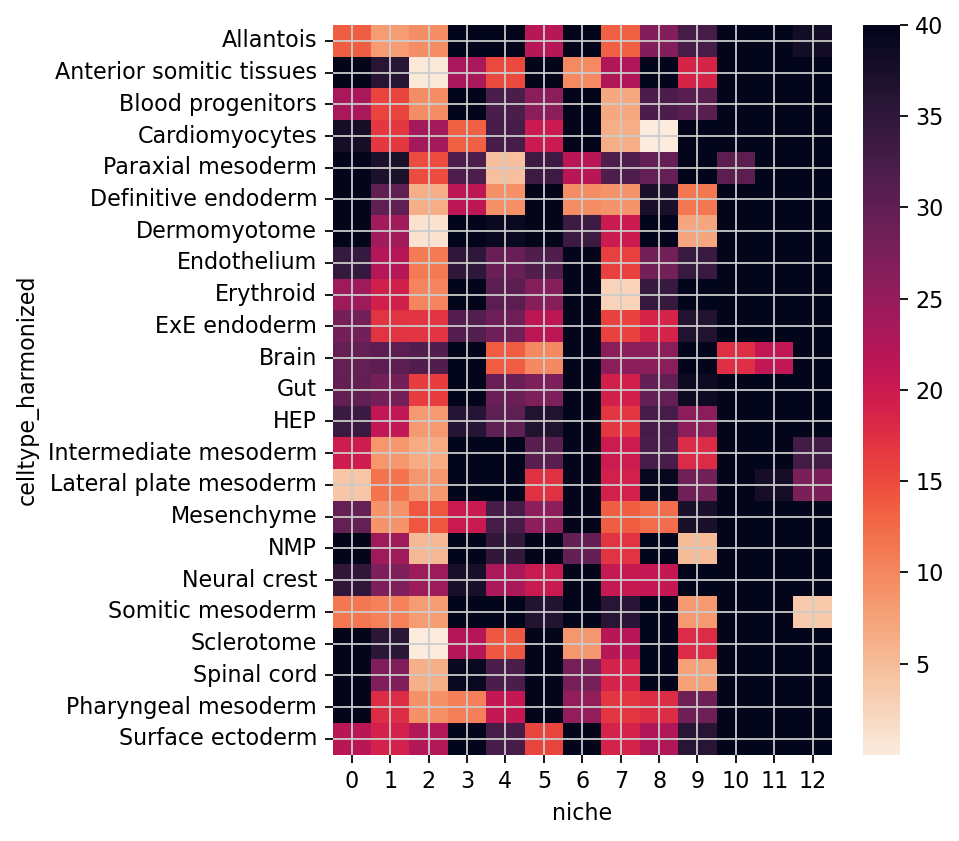

In [244]:
cell_type_to_niche = sopa.spatial.mean_distance(
    bdata,
    "celltype_harmonized",
    "niche",
)

plt.figure(figsize=(5, 6))
sns.heatmap(cell_type_to_niche, vmax=40, cmap=sns.cm.rocket_r)
plt.show()

This confirms that niches 10 and 11 localize with Brain cells, and to varying degrees with Paraxial mesoderm and Lateral plate mesoderm. (Note that we flipped the colormap here, as small distance means more association). 

For further analysis, let's vectorize niches as shapely polygons. 

In [245]:
gdf = sopa.spatial.geometrize_niches(bdata, "niche")

# sort categories
gdf["niche"] = gdf["niche"].astype("category")
sorted_cats = sorted(gdf["niche"].cat.categories, key=lambda x: int(x))
gdf["niche"] = gdf["niche"].cat.reorder_categories(sorted_cats)

gdf.head()

geometry niche      length  \
0  POLYGON ((1599.858 1340.817, 1599.861 1340.905...     0  451.198161   
1  POLYGON ((1580.637 1478.527, 1580.553 1478.569...     1  229.128449   
3  POLYGON ((1521.28 1397.199, 1521.289 1397.294,...    10  182.939196   
4  POLYGON ((1569.387 1347.454, 1569.457 1347.546...    11  115.868903   
5  POLYGON ((1652.895 1406.676, 1652.895 1406.766...    12  102.647683   

          area  roundness  
0  2086.080908   0.128768  
1  1220.819343   0.292215  
3   836.045761   0.313925  
4   568.129500   0.531769  
5   499.263299   0.595444

Each connected component of each niche is represented here as one polygon. Let's plot these in space. 

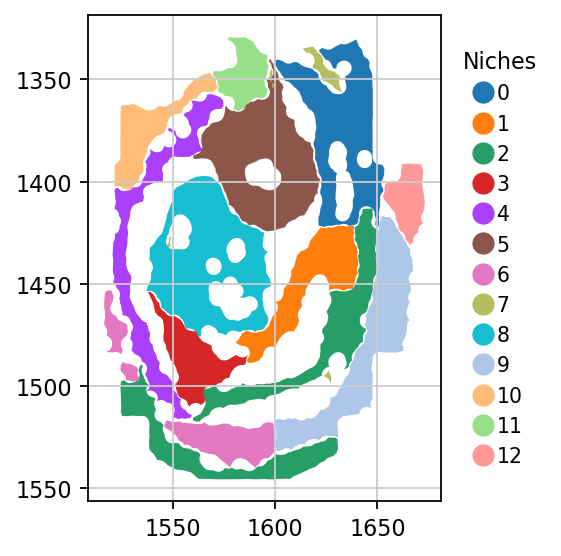

In [246]:
legend_kwds = {
    "bbox_to_anchor": (1.04, 0.5),
    "loc": "center left",
    "borderaxespad": 0,
    "frameon": False,
    "title": "Niches",
}

# make colors consistent with what we had above
niche_to_color = dict(zip(bdata.obs["niche"].cat.categories, bdata.uns["niche_colors"], strict=False))
niche_cmap = mcolors.ListedColormap([niche_to_color[cat] for cat in gdf["niche"].cat.categories])

ax = gdf.plot(column="niche", legend=True, cmap=niche_cmap, legend_kwds=legend_kwds)
ax.invert_yaxis()  # Flip the y-axis, to match our other plots above
plt.show()

Let's use sopa to compute simple geometric properties of each one of these niches, across embryos. 

In [247]:
df_niche_geom = sopa.spatial.niches_geometry_stats(bdata, "niche")

df_niche_geom.index = df_niche_geom.index.astype(int)
df_niche_geom = df_niche_geom.sort_index()

[INFO] (sopa.spatial.morpho) Computing pairwise distances between 20 components


Visualize these properties. 

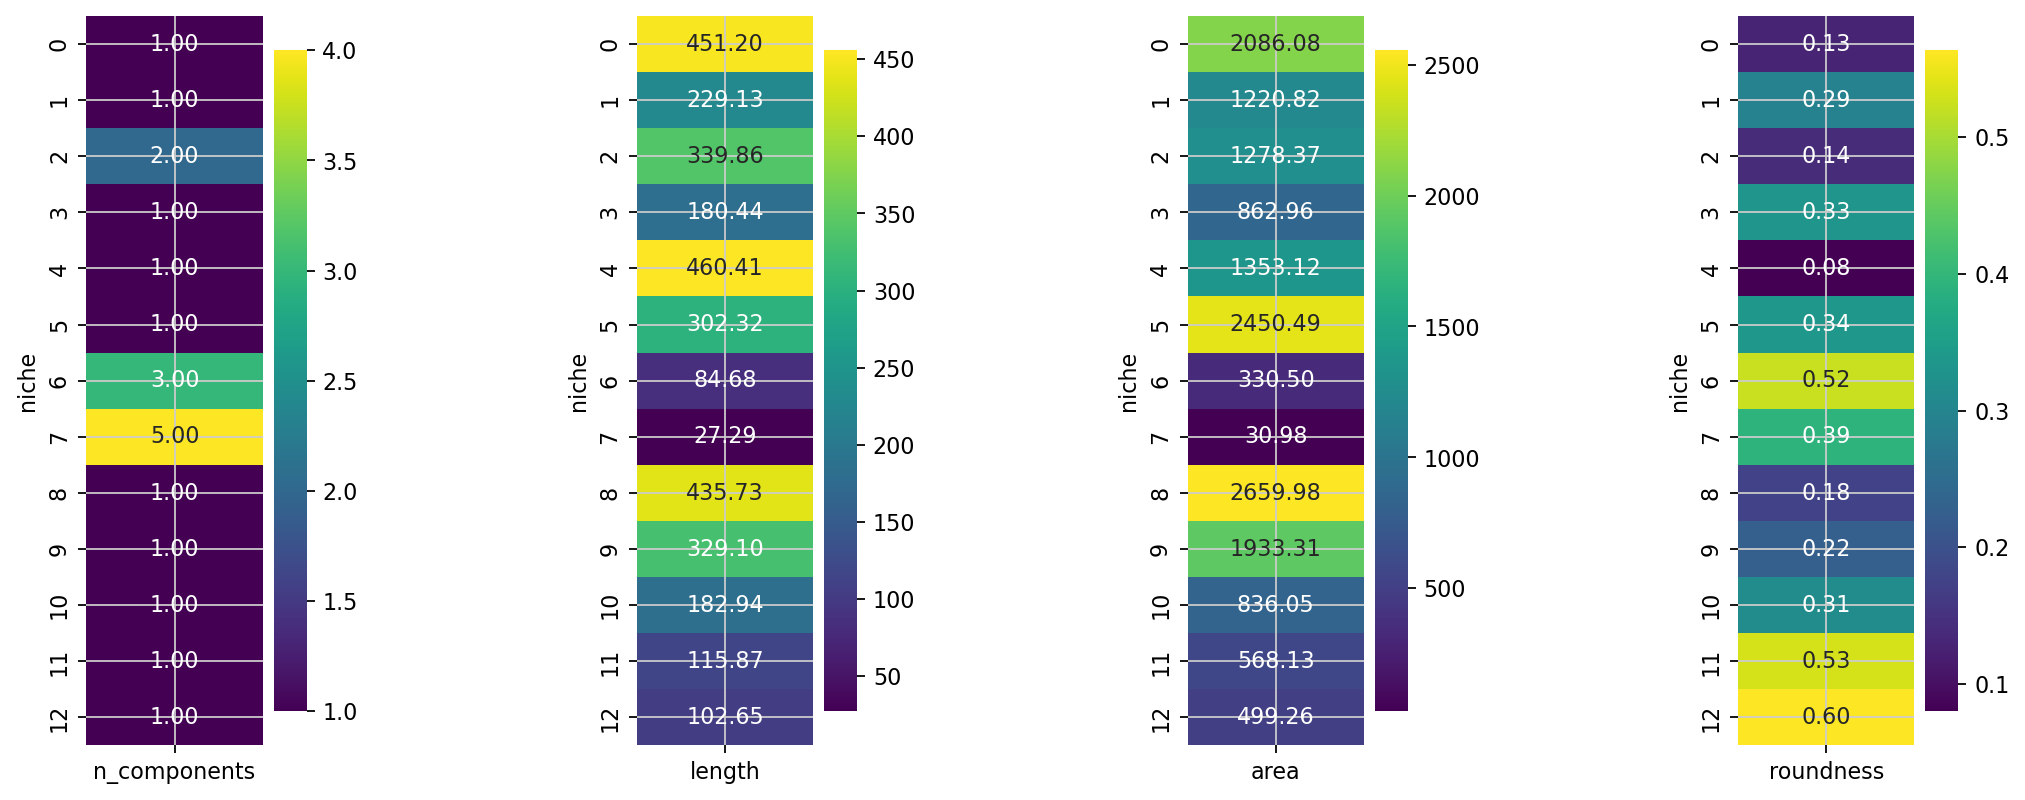

In [248]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))

for i, name in enumerate(["n_components", "length", "area", "roundness"]):
    vmax = df_niche_geom[name].sort_values()[-2:].mean()
    sns.heatmap(df_niche_geom[[name]], cmap="viridis", annot=True, fmt=".2f", vmax=vmax, ax=axes[i])

plt.subplots_adjust(wspace=1.5)

This confirms what we can see - e.g. niche 2 appears twice in this sample, niche 4 is the longest, niche 8 is the largest, and niche 12 is relatively round. 

### Compute a cell type to Niche network

Visualize a graph to gain a more global understanding of the relationship between niches and celltypes. Under the hood, Sopa uses [Netgraph](https://netgraph.readthedocs.io/en/latest/index.html) for the visualization. 

In [249]:
weights, node_color, node_size, node_shape = sopa.spatial.prepare_network(bdata, "celltype_harmonized", "niche")

[INFO] (sopa.spatial.distance) Computing all distances for the 4 pairs of categories
100%|██████████| 13/13 [00:00<00:00, 67.54it/s]


In [250]:
g = nx.from_pandas_adjacency(weights)
node_to_community = community_louvain.best_partition(g, resolution=1.35)

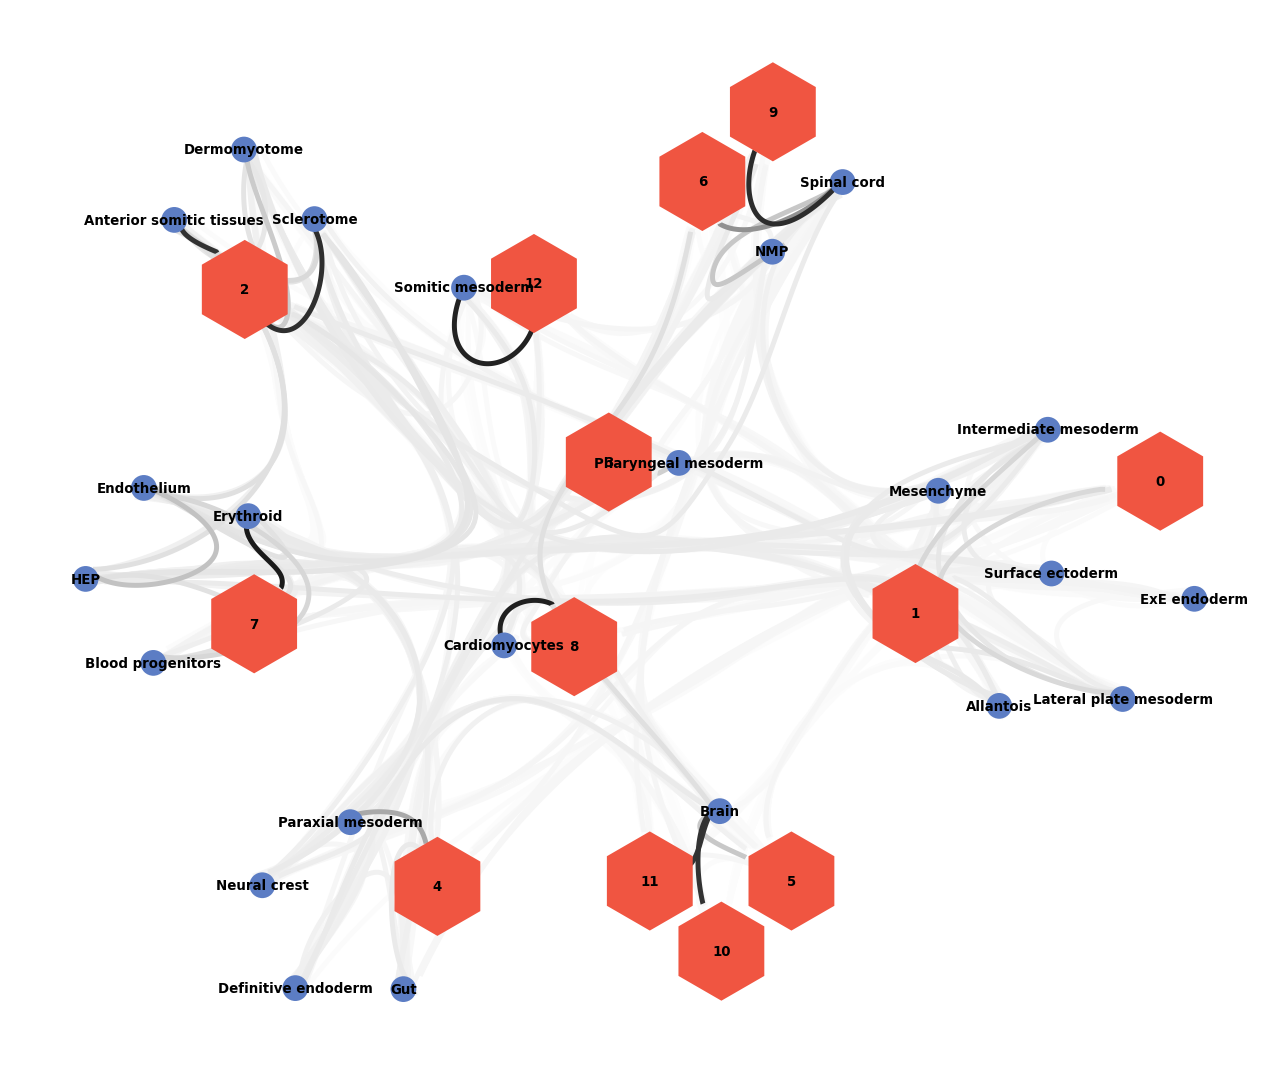

In [252]:
plt.figure(figsize=(10, 10))

Graph(
    g,
    node_size=node_size,
    node_color=node_color,
    node_shape=node_shape,
    node_edge_width=0,
    node_layout="community",
    node_layout_kwargs={"node_to_community": node_to_community},
    node_labels=True,
    node_label_fontdict={"size": 6, "weight": "bold"},
    edge_alpha=1,
    edge_width=0.5,
    edge_layout_kwargs={"k": 2000},
    edge_layout="bundled",
)

plt.show()

Given this graph, and what we learned about our niches above, we could now start annotating. 